# Image Style Transfer Using Convolutional Neural Networks

This notebook is intended to help breakdown the step by step process of the paper: *Image Style Transfer Using Convolutional Neural Networks* by Gatys et al. 

It will go through the code step by step to showcase how each block of code works. Let us first begin by loading our dependencies and mounting our Google Drive for use

In [29]:
# Mount Google Drive
from google.colab import drive
from google.colab.patches import cv2_imshow
import os
drive.mount('/content/drive')
# Change the working directory so that we have access to our files
os.chdir('/content/drive/My Drive/Engineering Projects/EE8601-Project2/project_builds')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [0]:
# DEPENDENCIES, VARIABLES, AND PATHS

# Libraries
import tensorflow as tf
import numpy as np
from tensorflow.python.keras import models
import os
import glob
from PIL import Image
from tensorflow.python.keras.preprocessing import image as tf_image
import matplotlib.pyplot as plt
import cv2

# Define paths
content_path = '/content/drive/My Drive/Engineering Projects/EE8601-Project2/project_builds/input/content/elon.jpg'
style_path = '/content/drive/My Drive/Engineering Projects/EE8601-Project2/project_builds/input/style/ironman.jpg'
init_path = '/content/drive/My Drive/Engineering Projects/EE8601-Project2/project_builds/input/init/512.jpg'
lena = '/content/drive/My Drive/Engineering Projects/EE8601-Project2/project_builds/input/content/lena_test.png'
lion = '/content/drive/My Drive/Engineering Projects/EE8601-Project2/project_builds/input/content/lion.jpg'
dog = '/content/drive/My Drive/Engineering Projects/EE8601-Project2/project_builds/input/content/dog.jpg'

# Part 1: Image Utilities

First and foremost, we have to define a couple of functions that will allow us to actually read the images and manipulate them for use in the VGG19 network. This next section will define functions to be used for image manipulation, including loading an image, preprocessing it for use in the VGG19 network, deprocessing it once it has been run through the network, and then saving the image itself.

## Function 1 - Load Image

In [0]:
# IMAGE UTILITIES - FUNCTION 1 - LOAD IMAGE

def load_img(img_path):
    # Read the image and convert the computation graph to an image format
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Setting the scale parameters to change the size of the image
    # Get the width and height of the image. Cast it to a float so it can be divided
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    # Set the absolute maximum dimension for the image
    max_dim = 1024
    
    # Find which side is the longer side, this will be used to generate our scale
    max_side = max(shape)
    scale = max_dim / max_side
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape, method=tf.image.ResizeMethod.BILINEAR)

    img = img[tf.newaxis, :]
    return img


### Example 1 - Load an Image

Let's run this code to see how it will work

In [32]:
# We will use the the Lena image as an example, the path to which was already defined above
# First read the image and see how a tensor works

img_ex= tf.io.read_file(content_path)
img_ex.shape

TensorShape([])

Okay, great! We successfully imported our image using Tensorflow's built in function. The caveat is that it reads the files as a *Tensor* instead the regular 3D matrix object format.. The problem with using PIL is how it *reads the image as an input*. That is, it doesn't actually read the image the way we want it to. If you're familiar with OpenCV (which I will now refer to as cv2), then you should know the progenitor function 

```
img = cv2.imread(path)
```
This is a very useful function since it reads the image as an actual array but since we're going to be manipulating the image using a CNN, we need to read it as a tensor.

If we tried to use cv2, t would return an error simply because of how OpenCv reads the image. Now the problem is, we can't extract any information about this image! 

It all boils down to how Tensorflow reads the image, it doesn't know it's an image since it creates a computation graph that needs to be evaluated. We can do this by using their command to decode this as an image. We're also going to take this time to convert the image from uint8 to float32 since we're going to need that flexibility down the road. Specifically, it's due to the means calculated from the ImageNet data set, which will be discussed further in this notebook.


TensorShape([2649, 2513, 3])

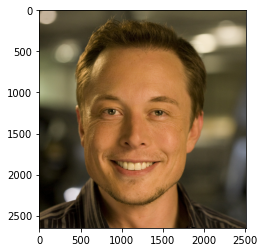

In [33]:
# Decode the input tensor into a displayable image format, while converting the data type to float
img_ex = tf.image.decode_image(img_ex, channels=3)
img_ex = tf.image.convert_image_dtype(img_ex, tf.float32)

# Display the image
plt.imshow(img_ex)
img_ex.shape

Now we see our image! We also wish to be able to quickly change our image dimensions for processing since our input style and content images must match dimensions. Let's take care of that.

First, we need to extract the width and height of the image so we can adjust them.

In [34]:
# Get the width and height of the image. Cast it to a float so it can be divided
shape = tf.cast(tf.shape(img_ex)[:-1], tf.float32)
shape

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2649., 2513.], dtype=float32)>

The Tensorflow shape function returns the shape of a tensor. The [:-1] at the end just makes it so that the shape its returning is one dimension LESS than whatever it currently is. Basically, it's dropping the colour channel dimension since we only care about the width and height. 

The Tensorflow cast function changes the tensor data type from one into another. The shape function would return an output that is of type integer. We want to be able to ADJUST the aspect ratio, which means we will be dividing it shortly. Thus, we want a float data type to ensure that the division goes smoothly.

Our maximum side is 2649 pixels long so it will be scaled down to 512 pixels.

The new dimension of our image is [512 485]


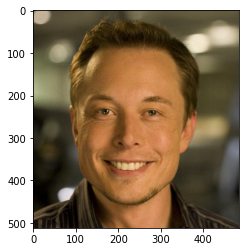

In [35]:
# Set the absolute maximum dimension for the image
max_dim = 512
# Find which side is the longer side, this will be used to generate our scale
max_side = max(shape)
scale = max_dim / max_side
print('Our maximum side is', np.array(max_side, dtype=np.uint32), 'pixels long so it will be scaled down to', max_dim, 'pixels.')
new_shape = tf.cast(shape * scale, tf.int32)
img_ex_a = tf.image.resize(img_ex, new_shape)
print()

# Display the image
plt.imshow(img_ex_a)
print('The new dimension of our image is', np.array(new_shape, dtype=np.uint32))

Notice what happened here. We essentially downsampled our image by applying a scaled value to each of its dimensions in the resize operation. 

Now that it has been resized, we're going to add an extra dimension in the front so it becomes a 4D object that the VGG19 network can take in.

In [36]:
img_ex_b = img_ex_a[tf.newaxis, :]
print('Our tensor has the dimensions:', img_ex_b.shape)


 # Sanity check to make sure our defined function works as well
img_ex_c = load_img(lena)
img_ex_c.shape

Our tensor has the dimensions: (1, 512, 485, 3)


TensorShape([1, 682, 1024, 3])

Great! Our first function works! Now let's define a couple more that we'll need to use. We need to deprocess the image once we've received it back from our CNN. Then, we need a function that will save our actual result. Finally, I'll define a modified imshow function to make it easy to see our images at any point during our examples

Let's define these below

## Function 2 - Deprocess Image

In [0]:
# IMAGE UTILITIES - FUNCTION 2 - DEPROCESS IMAGE

def deprocess_img(processed_img):
    processed_img = processed_img*255
    processed_img = np.array(processed_img, dtype=np.uint8)
    if np.ndim(processed_img)>3:
      assert processed_img.shape[0] == 1
      processed_img = processed_img[0]
    return Image.fromarray(processed_img)

## Function 3 - Save Image



In [0]:
# IMAGE UTILITIES - FUNCTION 3 - SAVE IMAGE

def save_img(best_img, path):
    img = Image.fromarray(best_img)
    img.save(path)

## Function X - Modified imshow

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

### Example 2 - Deprocessing an Image

Let's run through these functions to understand a little bit about how they work.

The deprocess_img() function essentially turns our tensor back into a 3D image once again. It also incorporates the mean values used to train teh VGG19 network with the ImageNet dataset since that's extremely important.

 The save_img() function is  pretty basic and self explanitory. Once our image utility functions are all verified, we can dive into the defining the actual model!

The deprocessed image with size (971, 1024)


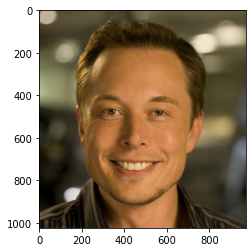

In [40]:
# Verify deprocess_img()

img_ex2 = load_img(content_path)
img_ex2_deproc = deprocess_img(img_ex2)

plt.imshow(img_ex2_deproc)
print('The deprocessed image with size', img_ex2_deproc.size)

# Part 2: The VGG19 Model

Now, we're going to define our model, specifically the VGG19 network. We'll be using Tensorflow to handle the actual model building, as well as Keras to make it easier to run the model itself. Every function built in this section corresponds to the theory outlined by Gatys' paper. 

Let's define some prerequisite knowledge first. Obviously we're going to need two images, the *content* image (which is what the actual subject of our final synthesized image will be) and the *style* image (which is the... style of our synthesized image... no easy way to describe that!). 

Next we need the model, which is obviously the VGG19 network. The VGG19 network is shown below

![Figure 1 - The VGG19 Network](https://drive.google.com/uc?id=17OkAl-I3Q1wTaYYhp3ZgvUcpgrxMKHCc&authuser=0)

The '19' in VGG19 is an indication of how many layers there are in the network. There are 16 convolutional layers and 3 fully connected layers. 

As stated before, we'll be using Keras to manipulate this network. Keras makes it easy since we don't need to build the network with its weights and biases from scratch. Let's load up the model and verify that all of its layers are included

In [41]:
# The argument, include_top, can be set to either 'True' or 'False'. In this case we 
# are setting it to True since we want to see ALL the layers. The include_top is specifically 
# the last 3 fully connected layers. Weights is the weights that are used for each layer, specifically
# the results that the network was trained with when the Imagenet data set was run through it 
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


Great, it loaded up correctly! Let's actually try it out and try to get a handle on what this CNN is capable of. We're going to pass an image of a lion into the actual thing. Before we do that, we have to call a Keras function that will preprocess the image for us to use in the VGG19 network. All this function does is extract the features from the image on a specified layer(s) to be used in the VGG19 model. Then run it through the VGG19 model to have it predict what's in the actual image itself. If the code works, it should give us a lion as its highest predicted output.

### Example 3 - Testing a Network

In [42]:
# Load the image. Remember that it's being loaded as a float so multiply it by 255
img_ex3 = load_img(lion)
ex3 = tf.keras.applications.vgg19.preprocess_input(img_ex3*255)

# Change the input size since the default input size of the VGG19 model is 224x224
img_ex3_b = tf.image.resize(ex3, (224, 224))

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(img_ex3_b)
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[print(class_name, '=', prob) for (number, class_name, prob) in predicted_top_5]

topprediction = predicted_top_5[0]
if topprediction[1] == 'lion':
  print('The top prediction is LION, our model works!')

lion = 0.99999964
cheetah = 1.8043703e-07
chow = 7.2701944e-08
macaque = 2.1276694e-08
tiger = 1.9176262e-08
The top prediction is LION, our model works!


Now we can get started on actually defining our first function of this section. Specifically, building our layer based on how the paper defines in. In the paper, only specific layers are used by Gatys. The content image is only passed to 'block4_conv2' and the style image is passed to 'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', and 'block5_conv1'. Let's start this section off by keeping these layers in their own array so we can call them up at any point 

To define a model using Keras we use the function


```
model = Model(inputs, outputs)
```

Let's write a function to SPECIFICALLY call upon the layers we want to use instead of all the layers being utilized by default

## Function 1 - The VGG19 Network 

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.python.keras import models

# Define which layers are to be used for this model. These layers are defined in Section 
# 3 of Gatys' paper
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# MODEL UTILITIES - FUNCTION 1 - VGG19 LAYERS

def get_vggLayers(style_or_content_layers):
    """
    Creates the model with intermediate layer access
    
    This function will load in the VGG19 model used in Gatys' paper, with access to the 
    intermediate layers. A new model will be generated by using these layers that will take an 
    input image and return an output from the intermediate layers from the VGG19 model

    Returns
    -------
    A Keras model that takes inputs and outputs of the style and content intermediate layers

    """
    # Instantiate the VGG19 model. We are not including the fully connected layers, instantiate the weight based off ImageNet training
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # VGG19 model is already trained off ImageNet, set trainable to False
    vgg.trainable = False
    
    # All we are doing is clipping the model accrodingly. Just set the input of the model to be the same as its original
    # The outputs are going to be set to the layers specified in either the style or content layers, this will
    # be set once you've passed one of them into the function as an argument
    vgg_input = [vgg.input]
    vgg_output = [vgg.get_layer(name).output for name in style_or_content_layers]
    model = tf.keras.Model(vgg_input, vgg_output)

    return model

### Example 4 - Creating a Model

Let's create a model using the style layers

In [44]:
# Load an image
style_img_ex4 = load_img(style_path)

# Extract the layers needed
style_extractor_ex4 = get_vggLayers(style_layers)

# Find the outputs
style_outputs_ex4 = style_extractor_ex4(style_img_ex4*255)

# Look at the stats of each layer's output
for name, output in zip(style_layers, style_outputs_ex4):
  print(name)
  print("  Shape: ", output.numpy().shape)
  print("  Min: ", output.numpy().min())
  print("  Max: ", output.numpy().max())
  print("  Mean: ", output.numpy().mean())
  print()

block1_conv1
  Shape:  (1, 1024, 1024, 64)
  Min:  0.0
  Max:  838.2029
  Mean:  38.70089

block2_conv1
  Shape:  (1, 512, 512, 128)
  Min:  0.0
  Max:  4707.831
  Mean:  215.44833

block3_conv1
  Shape:  (1, 256, 256, 256)
  Min:  0.0
  Max:  10762.438
  Mean:  265.72168

block4_conv1
  Shape:  (1, 128, 128, 512)
  Min:  0.0
  Max:  31911.98
  Mean:  800.5783

block5_conv1
  Shape:  (1, 64, 64, 512)
  Min:  0.0
  Max:  3708.13
  Mean:  54.836765



Perfect, now we know our function works as we want it to since it only returned details about the layers we called. We can try another example with the content layers to verify it once again

In [45]:
# Load an image
content_img_ex4 = load_img(content_path)

# Extract the layers needed
content_extractor_ex4 = get_vggLayers(content_layers)

# Find the outputs
content_outputs_ex4 = content_extractor_ex4(content_img_ex4*255)

# Look at the stats of each layer's output
for name, output in zip(content_layers, content_outputs_ex4):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block5_conv2
  shape:  (64, 60, 512)
  min:  0.0
  max:  1087.1655
  mean:  7.5524983



Now we REALLY know it works! Let's move onto the next part of the code. Specifically, the Gram matrix!

The Gram matrix is a bit tricky. It will essentially act as our style representation. At its core, the Gram matrix is the result of  multiplying a matrix with the transpose of itself. We normalize it by dividing it with the total number of elements in that layer. Let's make that function.

## Function 2 - The Gram Matrix

In [0]:
# MODEL UTILITIES - FUNCTION 2 - THE GRAM MATRIX

def gram_matrix(input_tensor):
  """
  Generates the Gram matrix representation of the style features. This function takes an input tensor and
  will apply the proper steps to generate the Gram matrix

  Returns
  -------
  A tensor object Gram matrix representation
  
  """
  # Equation (3)

  # Generate image channels. If the input tensor is a 3D array of size Nh x Nw x Nc, reshape
  # it to a 2D array of Nc x (Nh*Nw). The shape[-1] takes the last element in the shape
  # characterstic, that being the number of channels. This will be our second dimension
  channels = int(input_tensor.shape[-1])

  # Reshape the tensor into a 2D matrix to prepare for Gram matrix calculation by multiplying
  # all of the dimensions except the last one (which is what the -1 represents) together
  Fl_ik = tf.reshape(input_tensor, [-1, channels])

  # Transpose the new 2D matrix
  Fl_jk = tf.transpose(Fl_ik)

  # Find all the elements in the new array (Nw*Nh)
  n = tf.shape(Fl_ik)[0]

  # Perform the Gram matrix calculation
  gram = tf.matmul(Fl_jk, Fl_ik)/tf.cast(n, tf.float32)

  # Generate the Gram matrix as a tensor for use in our model
  gram_tensor = gram[tf.newaxis, :]
  return gram_tensor

In [0]:
# This is the Tensorflow backup, to be used in case my implementation doesnt work for whatever reason

def gram_matrix_(input_tensor):
  summation = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  result = summation/num_locations
  return result

### Example 5 - Understanding the Gram Matrix

Let's see how it actually works. First thing's first, we need a tensor to use for an example. Let's just input an image since our load_img() function instantiates the image as a tensor type object. Once we do that, we can extract the number of channels in the input

In [48]:
# Load an input image as an example tensor
style_img_ex5 = load_img(style_path)
print('The original shape of this tensor is', style_img_ex5.shape)

# Grab the number of channels in the image. The shape[-1] takes the last element in the shape 
# characterstic, that being the number of channels. This will be our second dimension
channels = int(style_img_ex5.shape[-1])

print('This input tensor has', channels, 'channels, which will be our new second dimension')

The original shape of this tensor is (1, 1024, 1024, 3)
This input tensor has 3 channels, which will be our new second dimension


Now let's reshape the input tensor accordingly. Since we're basically multiplying the matrix by its own transpose, we need to apply a matrix multiplication. We have to change this tensor into a 2D matrix. We'll use the Tensorflow reshape function to do that. By passing in our tensor as the first argument and then stating the bounds of the resulting output shape, we can make the 3D image (technically it's a 4D tensor, but since the first dimension has a value of 1, we'll disregard it knowing that this is an image) into a 2D matrix. the [-1, channels] makes it so that it takes all of the dimensions before the last dimension, that being [1, W, H] and multiplies them together. 

In [49]:
# Reshape the tensor into a 2D matrix to prepare for Gram matrix calculation
Fl_ik = tf.reshape(style_img_ex5, [-1, channels])

print('This tensor will be reduced by multiplying the first 3 dimensions together. Remember that Dimension 1 is of size 1')
print('Dimension 2 is of size', style_img_ex5.shape[1])
print('Dimension 3 is of size', style_img_ex5.shape[2])
print('Multiplying these together, the new size of the first element of the reshaped 2D matris is', style_img_ex5.shape[1]*style_img_ex5.shape[2])

# Verification of the above logic
if Fl_ik.shape[0] == style_img_ex5.shape[1]*style_img_ex5.shape[2]:
  print('Since Fl_ik has the new shape', Fl_ik.shape, 'our logic is correct')

This tensor will be reduced by multiplying the first 3 dimensions together. Remember that Dimension 1 is of size 1
Dimension 2 is of size 1024
Dimension 3 is of size 1024
Multiplying these together, the new size of the first element of the reshaped 2D matris is 1048576
Since Fl_ik has the new shape (1048576, 3) our logic is correct


Now let's actually start the Gram matrix calculation. We've already defined the matrix we need to multiply. Now, we just have to define its transpose and actually multiply the two matrices. 

While we're at it, we'll also grab the number of elements (pixels) in the image to normalize our Gram matrix. Once we do that we'll perform the matrix multiplication and normalization.

In [50]:
# Generate the transpose of our new 2D matrix
Fl_jk = tf.transpose(Fl_ik)

# Get number of elements in the full matrix
n = tf.shape(Fl_ik)[0]

# Perform the matrix multiplication
gram = tf.matmul(Fl_jk, Fl_ik)/tf.cast(n, tf.float32)

# Instantiate the Gram matrix as a tensor since it still represents our style features, at the end of the day
gram_tensor = gram[tf.newaxis, :]
print(gram_tensor)

# Sanity check
print(gram_matrix(style_img_ex5))
print(gram_matrix_(style_img_ex5))

tf.Tensor(
[[[0.5022685  0.32141384 0.2898315 ]
  [0.32141384 0.22958724 0.19764337]
  [0.2898315  0.19764337 0.19610038]]], shape=(1, 3, 3), dtype=float32)
tf.Tensor(
[[[0.5022685  0.32141384 0.2898315 ]
  [0.32141384 0.22958724 0.19764337]
  [0.2898315  0.19764337 0.19610038]]], shape=(1, 3, 3), dtype=float32)
tf.Tensor(
[[[0.5022685  0.32141384 0.2898315 ]
  [0.32141384 0.22958724 0.19764337]
  [0.2898315  0.19764337 0.19610038]]], shape=(1, 3, 3), dtype=float32)


## Function 3 - Style and Content Feature Extraction

We're going to build the model so that it can easily extract the style and content feature tensors. Specifically, we can do this by using a Python class, which is similar to classes in OOP like Java. Every Python class object has a "__init__()" function that is called every time the class is being used to create a new object. All this function does is assign values to the object properties that the object needs when it's being created.

In this case, we basically need to define all the properties related to making our model which we already know since we've done a couple of examples already. But it basically needs to know which model it's using and what layers it needs to activate on. All of this is related to the tf.keras.models.Model and can be defined using the self parameter

The "call()" method is called when the instance is called. When a variable of this class is called, this method is what is used to call it. Let's discuss what each line does. When we call this function, we provide an image input of type float32. The image is then multiplied by 255 such that it can be preprocessed for use in the VGG network. It's then passed through the network to provide the outputs. These outputs are split between the style and content outputs and placed in dictionaries so that it can be called upon when needed. The function returns both dictionaries which can be called upon if specificed. The style dictionary returns the gram matrix (style) of the style layers and the content of the content layers.

In [0]:
# MODEL UTILITIES - FUNCTION 3 - STYLE & CONTENT MODEL CLASS

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = get_vggLayers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  
  def call(self, inputs):
    # Expects a float input between [0, 1] 
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

    return{'content':content_dict, 'style':style_dict}


feature_extractor = StyleContentModel(style_layers, content_layers)

### Example 6 - Style and Feature Extraction

Let's try to extract the features and see what the model outputs. Our above function integrates the previously built functions to make our flow seamless

In [52]:
# Load an image
content_img_ex6 = load_img(content_path)

# A Tensorflow constant is different from a variable. A constant type makes it so that when you declare it,
# the actual value of it can't be changes
results_ex6 = feature_extractor(tf.constant(content_img_ex6))

# This line of the code technically doesn't do anything for this example but it's an example for how the results would be called
# further down the line. Basically, you can pull either the style or content results by calling the variable holding the 
# feature extractor outputs and specifying whether you wish to get the style or content results in a square bracket box
style_results_ex6 = results_ex6['style']

print('Styles:')
for name, output in sorted(results_ex6['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results_ex6['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0024659375
    max:  17750.146
    mean:  257.1598

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  31234.38
    mean:  5096.993

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  98666.7
    mean:  3463.4058

   block4_conv1
    shape:  (1, 512, 512)
    min:  3.2328677
    max:  966244.75
    mean:  76172.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  14113.433
    mean:  415.8068

Contents:
   block5_conv2
    shape:  (1, 64, 60, 512)
    min:  0.0
    max:  832.2692
    mean:  6.642741


## Function 4 - Gradient Descent and Loss Functions

Now that we're able to actually extract our features, we can implement the actual style transfer algorithm! We need to be able to compute the mean squared error for the image's output relative to each target. Following this, the weighted sum of each loss needs to be taken as well.

We first start off by actually loading our style and content image and then extracting their features. By calling on the class we defined earlier, we can specify the extracted feature based on the style and content as shown below.

Once this is done, we need an image to optimize. Remember that Equation 1 and Equation 4 are compared between the features (content or style) and the generated image. Thus, we need to generate this image. It can either be generated from the style image, content image, or even a generated white noise image. We can generate this using the tf.Variable function. This basically inititalizes a variable based on the shape and details of the input. 

Since this generated image is of a float32 type, we need to clip this between 0 and 1. Thus we need a function clip_range to do this for us.

In the paper, Gatys uses an optimisation strategy to find the optimal loss. The paper uses L-BFGS but this isn't available in Tensorflow. We'll use ADAM instead. This will optimize Equation 7 (Total Loss Equation), which uses the gradient WRT the generated image's pixel values as an input. Thus, to optimize this image, we need a weighted combination of the two losses to get the total loss, hence Equation 7. We state these weights as alpha and beta.

Once all of these are defined, we can define a function to calculate our loss functions.

In [0]:
# Load the style and content images
style_img = load_img(style_path)
content_img = load_img(content_path)

# Extract the features from the style and content images
style_features = feature_extractor(style_img)['style']
content_features = feature_extractor(content_img)['content']

# The Tensorflow variable function initializes our image to be used for gradient descent. 
# This image has to be the same size and type as the content image, which means that as long as it's loaded in before being 
# called upon as the generated image, it should be fine to use. This is essentially the image that will be optimized.
# In case you want to use another image, you can uncomment the code below
'''
init_img = load_img(content_path)
generated_image = tf.Variable(init_img)
'''
generated_img = tf.Variable(content_img)

# Remember that all of our images are read in as a float32 type, so we have to define the range as [0, 1] to keep it within 255
def clip_range(img):
  return tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)

# Choose an optimizer. The paper chose L-BFGS but Tensorflow doesn't have that, so we'll use ADAM
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-8)

# Remember that we are trying to optimize the Total Loss function. However, there are values that correspond to the style and content weight
# The Alpha value corresponds to content weight and the Beta corresponds to the style weight. Let's define these
alpha = 1e4
beta = 10

# MODEL UTILITIES - FUNCTION 4 - STYLE, CONTENT, & TOTAL LOSS FUNCTIONS

# Now we define our loss functions
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']

  # Equation 5
  # Define the style loss function
  style_loss = tf.add_n([tf.reduce_mean(tf.square(style_outputs[name] - style_features[name])) for name in style_outputs.keys()])
  # Multiply the style loss by the weighted variable to get the weighted style loss
  style_loss *= beta / num_style_layers

  # Equation 1
  # Define the content loss function
  content_loss = tf.add_n([tf.reduce_mean(tf.square(content_outputs[name] - content_features[name])) for name in content_outputs.keys()])
  # Multiply the content loss by the weighted variable to get the weighted content loss
  content_loss *= alpha / num_content_layers
  
  # Equation 7
  # Define the total loss function
  total_loss = style_loss + content_loss
  return total_loss


All this little script does is check if the GPU is being used. It doesn't really do anything for our actual code.

In [54]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Function 5 - Total Variational Loss

This part is aside from the paper. The basic implementation of this code produces a lot of high frequency artifacts. We want to get rid of these so we'll have to decrease these using an explicit regularization term on the high frequency components of the image. This is known as *total variational loss*. Technically, we can use Tensorflow's built in function to get this variational loss. However, we'll define the functions so that we UNDERSTAND how this works. At the end of the day, we essentially use tf.GradientTape to update the image using gradient descent

The high frequency component is essentially an edge detector. The regularization loss is associated with this is the sum of the squares of the values. The two functions are shown below

```
def high_pass(img):
  x_var = img[:, :, 1:, :] - img[:, :, :-1, :]
  y_var = img[:, 1:, :, :] - img[:, :-1, :, :]

  return x_var, y_var

def total_variational_loss(img):
  x_delta, y_delta = high_pass(img)
  return tf.reduce_sum(tf.abs(x_delta)) + tf.reduce_sum(tf.abs(y_delta))
```




In [0]:
# State the total variational weight
total_variational_weight= 30

@tf.function()
def train_step(img):
  # Tensorflow's GradientTape function performs automatic differentiation of the input
  with tf.GradientTape() as tape:
    outputs = feature_extractor(img)
    loss = style_content_loss(outputs)
    loss += total_variational_weight * tf.image.total_variation(img)

  # Apply the gradient by passing the loss and the generated image
  grad = tape.gradient(loss, img)

  # The gradient is optimized using the ADAM optimizer we declared earlier. This optimizes the 
  # generated image using the gradient values
  optimizer.apply_gradients([(grad, img)])

  # The image is rewritten, being sure that the values all stay within the viable range of [0, 1]
  img.assign(clip_range(img))

In [57]:
import time
from IPython import display
# Start the run time
start = time.time()

epochs = 100
iterations = 100

step = 0
for n in range(epochs):
  for m in range(iterations):
    step += 1
    train_step(generated_img)
    print(".", end=' ')
  display.clear_output(wait=True)
  display.display(deprocess_img(generated_img))
  print("Train step: {}".format(step))

end = time.time()
print("Total Time: {:.1f}".format(end-start))

# Save Image Files
file_name = '/content/drive/My Drive/Engineering Projects/EE8601-Project2/project_builds/output/stylized-image.png'
deprocess_img(generated_img).save(file_name)


Output hidden; open in https://colab.research.google.com to view.